In [19]:
import os
import import_ipynb
import pandas as pd
import itertools
import talib
import math
import numpy as np
from numpy import nan

'''to be modified and shift into property files'''
currentpath=os.getcwd()
dbpath=os.path.join(currentpath,"..",'database')
stockcsv=os.path.join(dbpath,'stockpath.csv')
stocktest=os.path.join(dbpath,'stocktest.csv')

featurescsv=os.path.join(dbpath,'features.csv')
featuresdata=os.path.join(dbpath,'featuresdata.csv')



#to import Load_Csv file from another directory. this style is for jupyter notebook
                
%cd ..
from utility import Load_Csv as lcsv
%cd stockprediction



C:\Prgs\Code\mokshtech\Fin_Product
C:\Prgs\Code\mokshtech\Fin_Product\stockprediction


In [20]:
class ta(lcsv.Load_csv):
    '''this class contains functions fto predict label with the help of technical indicators'''
    
    def __init__(self,symbol='NIFTY'):
        file=symbol+'.csv'
        self.filename=os.path.join(dbpath,file)  
    

    def loadcsv(self):
        '''load 'Date','Close', 'Volume' data from databse and return dataframe
        '''
        
        self.dataset=self.LoadData(self.filename).loc[:, ['Close','Open','Date','Volume']]
        self.dataset['Date'] = pd.to_datetime(self.dataset['Date'])
        self.dataset = self.dataset.fillna(self.dataset.mean())

        return self.dataset
    

    def loadfeaturesdata(self,x):
        '''load features detailed data from databse'''
        self.featuresdata=self.LoadfeaData(featuresdata)
        self.featuresdata.index=self.featuresdata[0]
        #self.featuresdata=self.featuresdata.loc[x]
        return list(self.featuresdata.loc[x,1:])
    
    
    def ti_Combinations(self):
        '''takes input as list of list and  gives output as comninations '''
        
        #print("ti_Combinations")

        self.paneldict={}
        def comb_r(row):
            
            #print(self.dataset)
            #print('row',row)
            comb_dataset=self.dataset.copy()#deep=True)  #Copy basic dataset to comb_dataset
            for i in row:
                #print('i',i)
                comb_dataset['MA'+str(i)]=self.tdf['MA'+str(i)] # add MA rows from tdf to comb_dataset as per the combination .
                #print('comb_dataset',comb_dataset)
            #print('c',comb_dataset)    #To print dataset with all combinations of MA
            
            #print('self.paneldict',self.paneldict)
            row_s=str(row)
            self.paneldict[row_s]=comb_dataset.copy()#deep=True)  # Now xfer dataframe from comb_dataset to panel_dict 
            #print('self.paneldict2',self.paneldict)


        try:
            a=self.tidict['MA']
            #print('combinations_input',a)
            #[[10],[50],[60-64]]
            comb_df=pd.Series(list(itertools.product(*a)))##get combinatons 
            #print('comb_df',comb_df)
            comb_df.apply(comb_r)
            #panel_dataset=pd.Panel(self.paneldict)
            #print('panel_dataset',panel_dataset)
         
            '''
            ### Error: Panel is not working here . 
            On printing panel it is printing merge of all unique columns for each dataframe.
            
            
            #print(item for item in panel_dataset.items])  # to print item name of panel
            #print('(2, 4, 60)',panel_dataset[(2, 4, 60)])
            
            '''
            
            
        except Exception as e:
            print('e2',e)         
       
        
    def loadfeatures(self):
        '''load feature label data from databse
        '''
        self.featurestilist=[]
        self.misc=[]
        self.label=[]
        self.tilist=dir(talib)
        self.featuredict={}
        self.tidict={}
        self.features=self.LoadfeaData(featurescsv)

         
        def func(value,args):
           

            if str(value).find("-")>-1:   #tocheck if range is given 
                a,b=value.split("-")
                a=int(a)
                b=int(b)

                self.featuredict[args].extend(list(range(a,b)))   #if range is given then replace it by list
                self.tidict[args].append(list(range(a,b))) 
               
            else:
                try:
                    var=str(args)+'-'+str(int(value))              #togenerate name like MA-1,MA-2  

                    self.featuredict[args].extend(self.loadfeaturesdata(var))
                    
                    self.tidict[args].append(self.loadfeaturesdata(var))
                except Exception as e:
                    pass  
        
        
        def funr(row):
            r_len=len(row)
            ti=row[0]
            rowdf=pd.Series(row[1:])
            
                     
            if ti in self.tilist:
                self.featuredict[ti]=[]
                self.tidict[ti]=[]
                self.featurestilist.append(ti)
                
                rowdf.apply(func,args=(ti,))    #Vectorize function over each element
                
            elif ti=='label':
                self.label.append(row[1])
            elif ti == 'predict_days':
                self.predict_days = row[1:].tolist()
            else:
                self.misc.append(row)
    
                
                                                 #vectorize approach to speed up process        
        self.features.apply(funr, axis=1)
        #print(self.featuredict)                  #To be removed after development
        #print(self.features)
        #print("end")
        
        
        
        #return(self.featurestilist,self.label,self.misc,self.MA_comb)
        
        
        
    def get_MA(self,x):
        malist=self.featuredict['MA']
        for i in malist:
            if ('MA'+str(i)) in self.tdf:
                continue
            else: 
                try:
                    self.tdf['MA'+str(i)]=talib.SMA(self.dataset[x],i)
                except Exception as e:
                    pass
        return(self.tdf)
        
    def get_RSI(self,x):
        rsilist=self.featuredict['RSI']
        for i in rsilist:
            if ('RSI'+str(i)) in self.tdf:
                continue
            else:
                try:
                    self.dataset['RSI'+str(i)]=talib.RSI(self.dataset[x],i)
                except Exception as e:
                    pass
        return(self.dataset)
    
    
    def get_BBANDS(self,x):
        upper , middle , lower = talib.BBANDS(self.dataset[x],timeperiod=10,nbdevup=2,nbdevdn=2)
        self.dataset['upper']=upper
        self.dataset['lower']=lower
        self.dataset['upp-low']=upper-lower        
        
    def get_technical_indi(self):
        
        self.tdf=self.LoadData(stockcsv).loc[:, ['Close']]
        for i in self.featurestilist:
            if i=='MA':
                self.get_MA('Close')
            if i=='RSI':
                self.get_RSI('Close')
            if i == 'BBANDS':
                self.get_BBANDS('Close')
                
                
    def get_return(self):
        self.dataset['Daily_Return'] = self.dataset['Close'].pct_change()
        
        
    def get_label(self):
        print("start technical analysis and  Calculate technical indicators")
        if self.label[0]=='return':
            self.get_return()
        #print(self.dataset)
        #print(self.tdf)
        #print(self.tidict)
       
    def get_panel_data(self):
        self.loadcsv()
        self.loadfeatures()
        self.get_technical_indi()
        self.get_label()
        self.ti_Combinations()
        return self.paneldict

        
        
        

In [21]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import matplotlib.pyplot as plt
from datetime import date
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class ml_dpmodels(object):
    def __init__(self,predict_days=1,symbol='NIFTY'):
        self.predict_days=int(predict_days)
        self.report_dict={}
        self.symbol=symbol
        
        
    def data_preprocessing(self,train_paneldict,skipdays):
        
        test_size=0.3 #b.test_size  #to split dataset in training and testing part. 
      

        df_total = train_paneldict.iloc[:, 0:]
        y = train_paneldict.iloc[self.predict_days:, 0:1] #Close  # implement method to get label from file
        
        self.df=df_total.iloc[:-self.predict_days,:]
        
        # create report header
        header = (("_".join(str(i) for i in self.df.columns.tolist() if i.startswith('MA')))+'_'+self.symbol)
        print('header',header)
        self.report_dict[header] = pd.DataFrame(columns=['MSE','RMSE'],index=[header])

        
        #feature scaling 
        self.sc = MinMaxScaler(feature_range = (0, 1))
        df_total_scaled = self.sc.fit_transform(df_total) # This is total dataset
        #print('df_total_scaled',df_total_scaled[-15:])
        y_scaled = self.sc.fit_transform(y)
        forcast_scaled = df_total_scaled[-self.predict_days:] 
        #print('forcast_scaled',forcast_scaled[-10:])
        df_scaled = df_total_scaled[:-self.predict_days] 
        #print('df_scaled',df_scaled[-5:])

      
        ### Split Data set as per test size. 
        splitcount=int(df_scaled.shape[0]*test_size)+1

        '''
        df_scaled_shape=df_scaled.shape[0]
        
        X_train=df_scaled[:(df_scaled_shape-splitcount),:]
        X_test=df_scaled[(df_scaled_shape-splitcount):,:]
        
        #self.X_test_df=df_total.iloc[-(self.predict_days+splitcount):-self.predict_days,:]
        
        y_train=y_scaled[:(df_scaled_shape-splitcount),:]
        y_test=y_scaled[(df_scaled_shape-splitcount):,:]
        '''
        
        
        self.y_test_df=y.iloc[-(self.predict_days+splitcount):-self.predict_days,:]
        #'''
        #Creating data sctructure for test and training
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_scaled, test_size=test_size)
        X_train, y_train = np.array(X_train), np.array(y_train)

        #'''

        #Reshape xtrain and xtest to fit in lstm model

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        forcast_scaled = np.reshape(forcast_scaled, (forcast_scaled.shape[0], forcast_scaled.shape[1], 1))
        
        self.X_test , self.X_train , self.y_test , self.y_train ,self.forcast_scaled = X_test , X_train , y_test , y_train ,forcast_scaled


        return(self.X_test,self.X_train,self.y_test,self.y_train,forcast_scaled,header)

        
    def build_predictmodel(self,dataframe,skipdays):
        # Initialising the RNN
        
        
        LSTM_units=50
        LSTM_unit_increment=30
        dropoutunit=0.2
        
        
        X_test , X_train , y_test , y_train,forcast_scaled,header  = self.data_preprocessing(dataframe,skipdays)
        
        
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(dropoutunit))

        LSTM_units=LSTM_units+LSTM_unit_increment

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = LSTM_units, return_sequences = True))
        regressor.add(Dropout(dropoutunit))


        # Adding a third LSTM layer and some Dropout regularisation
        LSTM_units=LSTM_units+LSTM_unit_increment

        regressor.add(LSTM(units = LSTM_units, return_sequences = True))
        regressor.add(Dropout(dropoutunit))

        # Adding a fourth LSTM layer and some Dropout regularisation
        LSTM_units=LSTM_units+LSTM_unit_increment
        regressor.add(LSTM(units = LSTM_units))
        regressor.add(Dropout(dropoutunit))

        
        #print(X_train.shape,y_train.shape)
        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting the RNN to the Training set
        
        regressor.fit(X_train, y_train, epochs = 20, batch_size = 200)
        
        score = regressor.evaluate(X_test, y_test, batch_size=100, verbose=0)

        # Result (MSE adn RMSE)
        TM_MSE = score
        TM_RMSE = math.sqrt(score)
        self.report_dict[header] = pd.DataFrame(columns=['MA_comb','MSE','RMSE'],index=[header])
        self.report_dict[header].set_value(header,'MSE',TM_MSE)
        self.report_dict[header].set_value(header,'RMSE',TM_RMSE)
        self.report_dict[header].set_value(header,'MA_comb',header)


        

        
        
        print('TM_MSE : {0} ,TM_RMSE : {1}'.format(TM_MSE,TM_RMSE))
        
        return(regressor,X_test , X_train , y_test , y_train,forcast_scaled,header)


    def predict_forcast(self,dataframe,skipdays):
        
        dataframe = dataframe.fillna(dataframe.mean())
        dataframe = dataframe.set_index('Date')
        dataframe = dataframe.iloc[skipdays:,:]
        regressor,X_test , X_train , y_test , y_train,forcast_scaled,header=self.build_predictmodel(dataframe,skipdays)

        # Part 3 - Making the predictions and forcasting the results
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = self.sc.inverse_transform(predicted_stock_price)
        y_test = self.sc.inverse_transform(y_test)
        
        forcast_stock_price = regressor.predict(forcast_scaled)
        forcast_stock_price = self.sc.inverse_transform(forcast_stock_price)
        
        try:
            self.report_dict[header].set_value(header,str(self.predict_days)+'-Day', forcast_stock_price[-self.predict_days])
            #self.report_dict[header].set_value(header,'1-Day', forcast_stock_price[-self.predict_days+1])
            #self.report_dict[header].set_value(header,'15-Day', forcast_stock_price[-self.predict_days+15])
            #self.report_dict[header].set_value(header,'22-Day', forcast_stock_price[-self.predict_days+22])
            #self.report_dict[header].set_value(header,'44-Day', forcast_stock_price[-self.predict_days+44])
        except Exception as e:
            print('reporterror',e)

        
        
        print('forcast_stock_price for {0}-D-{2} is {1}'.format(self.predict_days,forcast_stock_price[-1],header))
        self.report_dict[header] = self.report_dict[header].set_index('MA_comb')

        print(self.report_dict[header])
        self.report_dict[header].to_csv('my_report.csv', mode='a', header=True,index=True)

        
        
        # Creating Data Frame for visualisation and storage.
        print(len(predicted_stock_price),self.y_test_df.shape)
                

        self.y_test_df['predicted price']=predicted_stock_price
        df=dataframe[['Close']]


        df = df.rename(columns={'Close': 'Historic  Price'})
        result = pd.concat([df,self.y_test_df], axis=1)
        result = result.rename(columns={'Close': 'Real test  Price'})  

        
        fs_df = dataframe.tail(n=self.predict_days)
        fs_df['forcast_stock_price'] = forcast_stock_price
        fs_df_modified = fs_df[['forcast_stock_price']]
        result = pd.concat([result,fs_df_modified], axis=1)
 
            # Visualising the results
        width = 18
        height = 10        
        
        result.plot(legend=True ,title='Stock Price Prediction '+header, figsize=(width, height))
        plt.grid(color='b', linestyle='--', linewidth=1)
        #plt.show()
        
        
        




    
    
    


start technical analysis and  Calculate technical indicators
header MA5_MA8_MA13_NIFTY
Epoch 1/20
327/327 [==============================] - 19s 58ms/step - loss: 0.2592
Epoch 2/20
327/327 [==============================] - 1s 2ms/step - loss: 0.1911
Epoch 3/20
327/327 [==============================] - 1s 2ms/step - loss: 0.1038
Epoch 4/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0552
Epoch 5/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0770
Epoch 6/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0420
Epoch 7/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0540
Epoch 8/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0601
Epoch 9/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0520
Epoch 10/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0415
Epoch 11/20
327/327 [==============================] - 1s 2ms/step - loss: 0.0417
Epoch 12/20
327/32

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


TM_MSE : 0.017592473021635774 ,TM_RMSE : 0.13263662021340777


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


forcast_stock_price for 60-D-MA5_MA8_MA13_NIFTY is [10074.74]
                          MSE      RMSE        60-Day
MA_comb                                              
MA5_MA8_MA13_NIFTY  0.0175925  0.132637  10104.151367
141 (141, 1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


header MA5_MA8_MA13_NIFTY
Epoch 1/20
368/368 [==============================] - 12s 32ms/step - loss: 0.2879
Epoch 2/20
368/368 [==============================] - 1s 2ms/step - loss: 0.2012
Epoch 3/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0875
Epoch 4/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0531
Epoch 5/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0607
Epoch 6/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0296
Epoch 7/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0466
Epoch 8/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0491
Epoch 9/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0397
Epoch 10/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0273
Epoch 11/20
368/368 [==============================] - 1s 2ms/step - loss: 0.0290
Epoch 12/20
368/368 [==============================] - 1s 2ms/step - loss: 0.03

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


TM_MSE : 0.008417404567201933 ,TM_RMSE : 0.09174641446510012


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


forcast_stock_price for 1-D-MA5_MA8_MA13_NIFTY is [9851.547]
                          MSE       RMSE        1-Day
MA_comb                                              
MA5_MA8_MA13_NIFTY  0.0084174  0.0917464  9851.546875
159 (159, 1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


header MA5_MA8_MA13_NIFTY
Epoch 1/20
359/359 [==============================] - 7s 20ms/step - loss: 0.2946
Epoch 2/20
359/359 [==============================] - 1s 2ms/step - loss: 0.2024
Epoch 3/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0769
Epoch 4/20
359/359 [==============================] - 1s 1ms/step - loss: 0.0579
Epoch 5/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0557
Epoch 6/20
359/359 [==============================] - 1s 1ms/step - loss: 0.0279
Epoch 7/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0454
Epoch 8/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0485
Epoch 9/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0376
Epoch 10/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0249
Epoch 11/20
359/359 [==============================] - 1s 2ms/step - loss: 0.0297
Epoch 12/20
359/359 [==============================] - 1s 2ms/step - loss: 0.032

467/467 [==============================] - 1s 2ms/step - loss: 0.0603
Epoch 5/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0442
Epoch 6/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0564
Epoch 7/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0425
Epoch 8/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0342
Epoch 9/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0404
Epoch 10/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0301
Epoch 11/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0296
Epoch 12/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0253
Epoch 13/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0228
Epoch 14/20
467/467 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 15/20
400/467 [========================>.....] - ETA: 0s - loss: 0.0173

KeyboardInterrupt: 

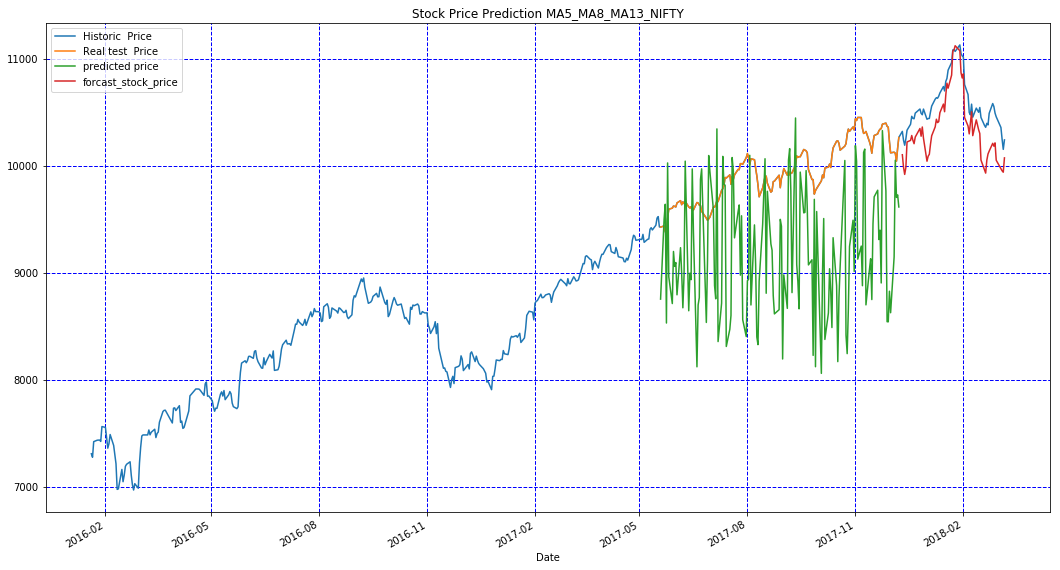

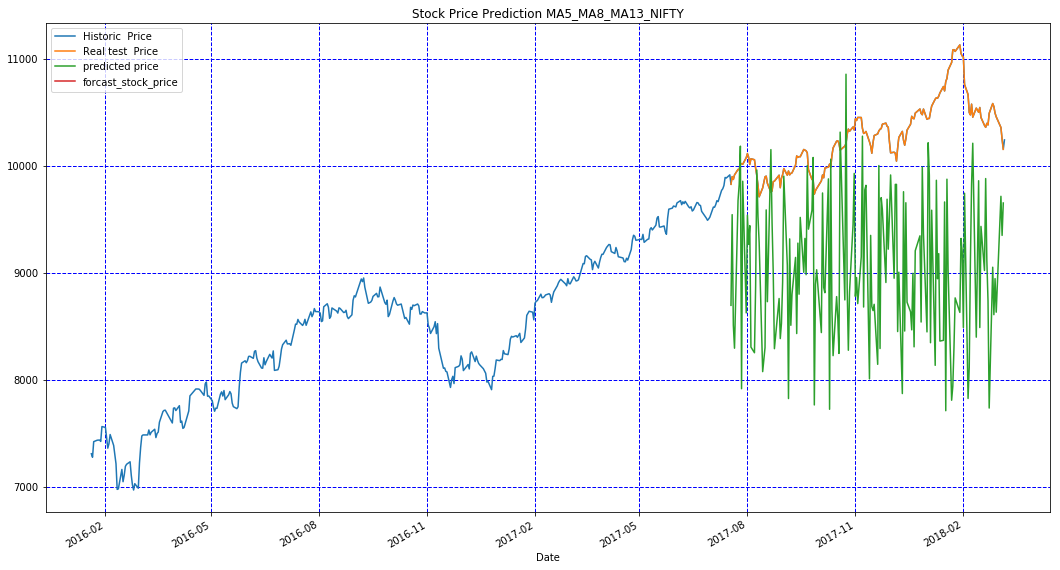

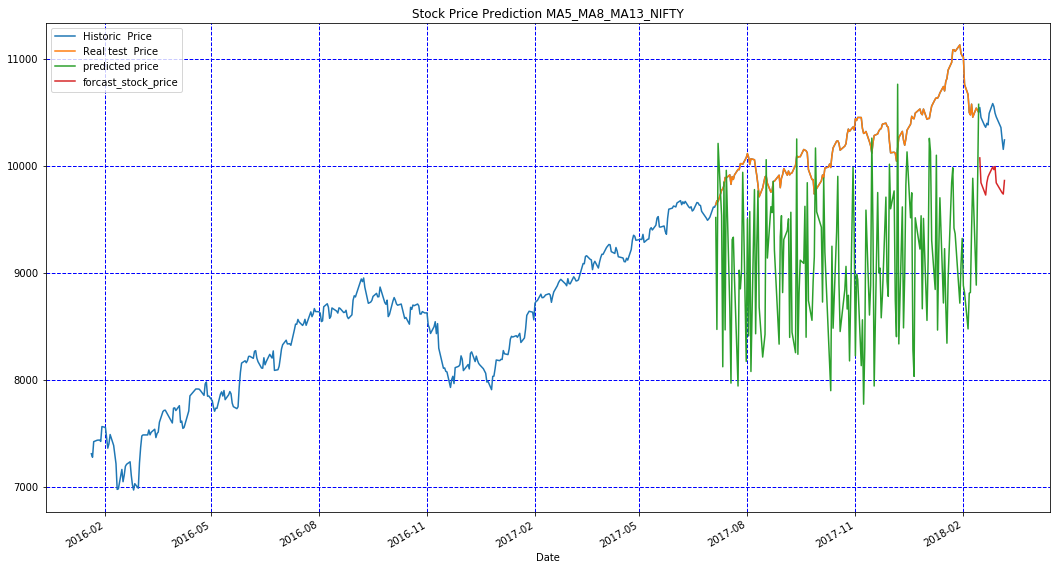

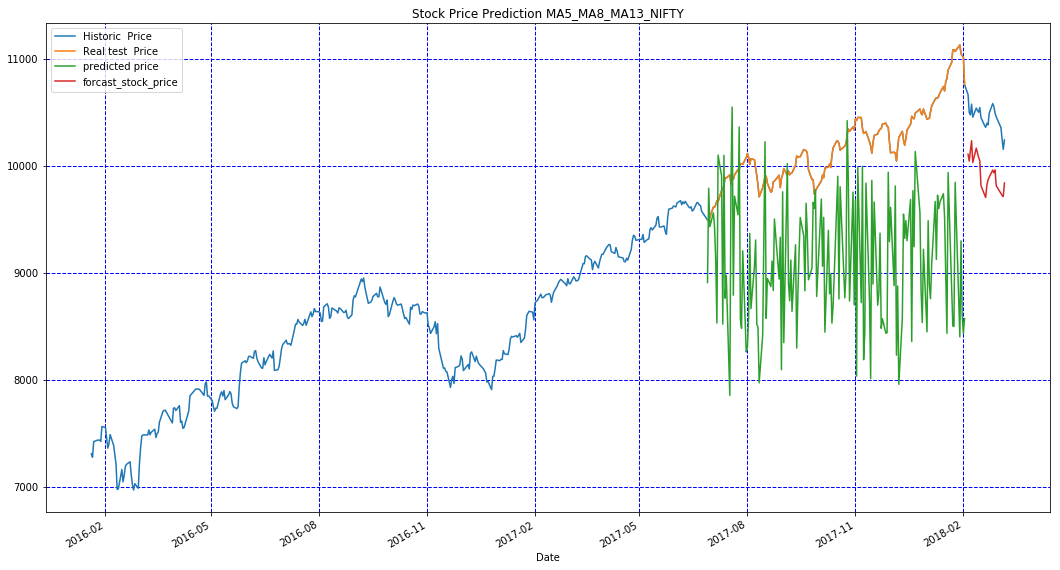

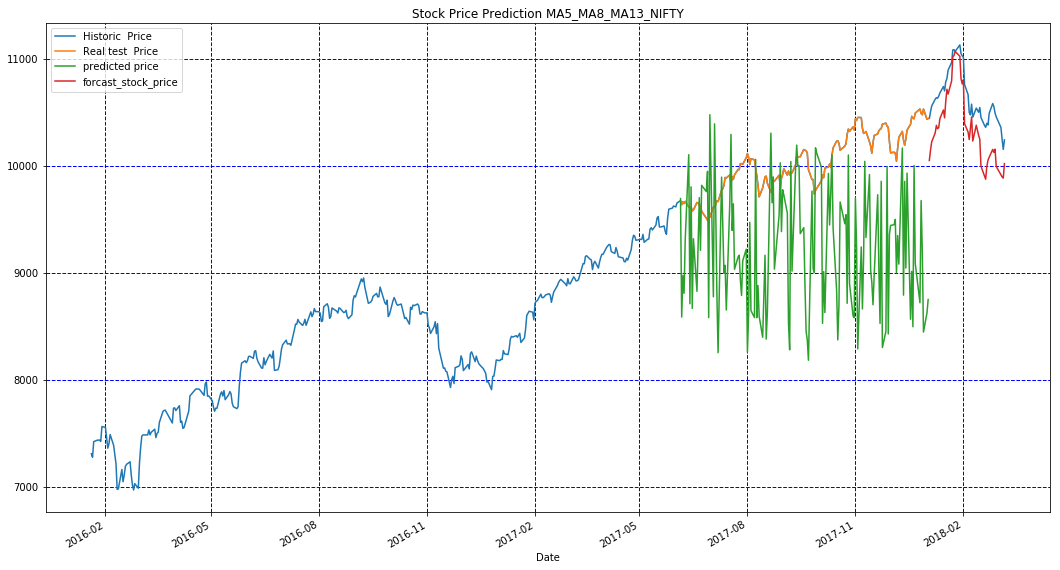

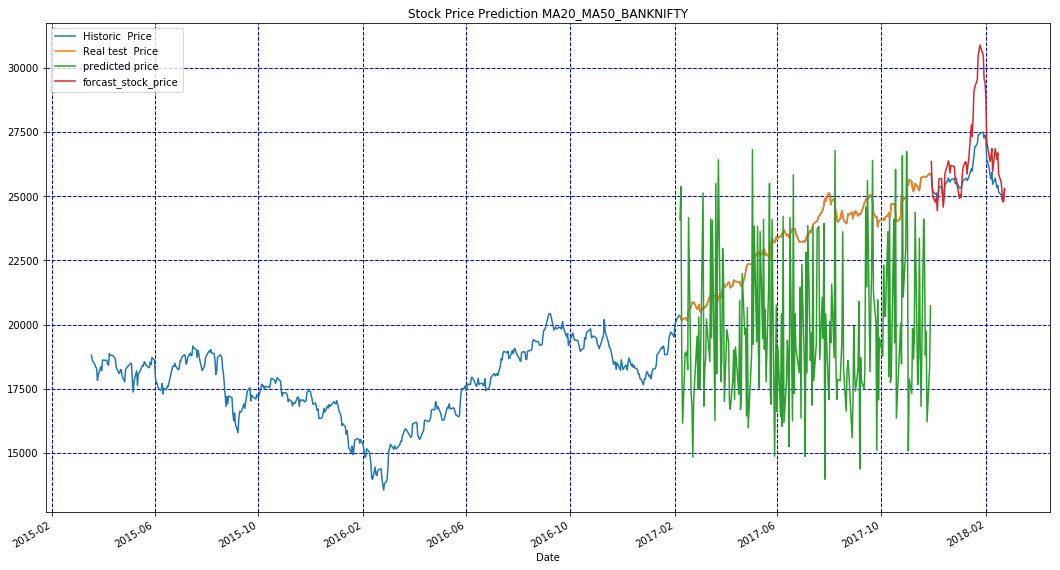

In [22]:
def start_run(symbol):
    b=ta(symbol)
    data=b.get_panel_data()
    skip_days=sorted([(sorted(v).pop()) for k,v in b.featuredict.items()]).pop()

    
    def funcseries(x):
        t=ml_dpmodels(int(x),symbol)
        d2 = dict((k,  t.predict_forcast(v,skip_days)) for k,v in data.items())
        
    list(map(funcseries,b.predict_days))
  
stocklist=['NIFTY','BANKNIFTY']#,'NIFTYIT','NIFTYCPSE','NIFTYMID50']
list(map(start_run,stocklist))

